In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# Проверка гипотез
Варианты:
1. Вышедший показатель хуже/лучше ожидаемого оказывает негативное/позитивное влияние на будущие доходности в событийном окне.
1. Средние Abnormal доходности до выхода события равны средним abnormal return после выхода события.
1. В среднем доходности акций до события говорят о гепе вверх или вниз на событии.
2. Годовые показатели 
3. Различия для компаний большой и малой капитализации
4. Различия по отраслям
5. Проверка на инсайдерскую информацию до выхода события
6. Геп тем выше, чем больше сюрприз по показателю
7. Годовые сюрпризы больше порождают реакцию, чем промежуточные

# Создать массивы p-value проверки гипотез
Проверяемая гипотеза H0: в средние доходности до выхода события не отличаются от средних доходностей после выхода события. Создается массив размерностью days_before на days_after, где на пересечении значений p-value проверки гипотез об одинаковых средних доходностях.

Ось по вертикали доходности до события, по горизонтали - после события.

#### Загрузка данных
При загрузке данных после события исключается день выхода отчета (геповая доходность в первый день торговли после события).

In [6]:
# Информация по отчетам
earns = pd.read_csv('./data/earns.csv', low_memory=False)

# Логарифмические доходности
edata_before_adj_logret = pd.read_csv('./data/edata_before_adj_logret.csv', index_col=None, header=None).values
edata_after_adj_logret = pd.read_csv('./data/edata_after_adj_logret.csv', index_col=None, header=None).values
market_before_logret = pd.read_csv('./data/market_before_logret.csv', index_col=None, header=None).values
market_after_logret = pd.read_csv('./data/market_after_logret.csv', index_col=None, header=None).values

# Вектор бет
beta_ = pd.read_csv('./data/beta_before_adj.csv', index_col=None, header=None, skip_blank_lines=False).values

# Abnormal return 
edata_before_abn = edata_before_adj_logret - market_before_logret*beta_
edata_after_abn = edata_after_adj_logret - market_after_logret*beta_

edata_before_abn.shape, edata_after_abn.shape

((38239, 199), (38239, 40))

#### Загрузить словарь данных, содержащихся в массиве показателей

In [7]:
# Импорт названий листов с данными
sheets = pd.read_csv('./data/sheets.txt', header=None).values.T[0].tolist()

# Импорт названий столбцов на соответствующих листах
sheets_columns = pd.read_csv('./data/sheets columns.txt', header=None, sep='\t').values

# Словарь-  лист: названия столбцов на листе
sname = dict((sheet,values.tolist()) for sheet,values in zip(sheets,sheets_columns))

## Функция создания массива p_values
Функция возвращает массив dataframe p-value значений. 
Пример: в ячейке (5,7) содержится p-value c проверкой нулевой гипотезы о том, что средние доходности за последние 5 дней до выхода события равны средним доходностям за 7 дней после события.

- data_before - доходности до выхода события
- data_after - доходности после события
- days_before - количество дней до события для проверки
- days_after - количество дней после события для проверки

In [8]:
def matrix_pval(data_before, data_after, days_before, days_after):
    # Преаллокация для заполнения
    pvals_return = np.empty((days_before, days_after))
    pvals_return[:] = np.nan

    for days_b in range(1,days_before+1):
        # Доходность за последние days_b до выхода события
        ret_before = np.sum(data_before[:,-days_b:], axis=1)

        for days_a in range(1,days_after+1):
            ret_after = np.sum(data_after[:,:days_a], axis=1)

            # Убрать nan значения
            not_nan = ~((np.isnan(ret_before) | np.isnan(ret_after)))

            p_val = stats.ttest_ind(ret_before[not_nan], ret_after[not_nan], axis=0, equal_var=True).pvalue

            pvals_return[days_b-1, days_a-1] = p_val

    # в датафрейм
    p_vals = pd.DataFrame(pvals_return, index=np.arange(1,days_before+1), columns=np.arange(1,days_after+1))
    
    return round(p_vals,4)

## Функция для отрисовки heatmap
Если указана alpha (уровень значимости) матрица p_val заменяется 1 если нулевая гипотезу принимаем, и 0 в другом случае

In [42]:
def plot_heat(data, alpha=None, title='', n_examples=None, savefig=False, prename='', cmap='Greens'):
    
    # Если все значения nan, заполнить массив нулями
    if data.isnull().all().all():
        data[:]=0
        
    # Если указана альфа - заполнить нулями и единицами
    if alpha is not None:
        for a_,a in zip(alpha[:-1], alpha[1:]):
            data[(data>a_)&(data<=a)] = a
        data[data>alpha[-1]] = 1

    fig, ax = plt.subplots(figsize=(24, 12))
    sns.heatmap(data, vmin=0, vmax=1, cmap=cmap, linewidths=0.05, linecolor='silver', square=True)
    
    # Заголовок. Добавить колв-во наблюдений если указано
    if n_examples is not None: title += ' (наблюдений: ' + str(n_examples) + ')'
    ax.set_title(title, fontsize=24)
    
    # Сохранить
    if savefig:
        # Добавить пробел после prename
        if len(prename)!=0: prename=prename+' '
        
        # Сохранить
        fig.savefig(prename + title.replace(':','') + '.png', bbox_inches='tight', pad_inches=0.6)

## Выбор показателей и ситуации для отображения

In [10]:
# Для хранения всех фильтраций
filter_ = pd.DataFrame()

# Для хранения всех заголовков графиков
title = []

for show_for in sname.keys():

    # Столбцы показателя
    vals_name = sname[show_for]
    act_value = [s for s in vals_name if 'ActValue' in s][0]
    mean_value = [s for s in vals_name if 'Mean' in s][0]

    # Разница актуального с ожидаемым
    shock_dif = earns[act_value] - earns[mean_value]

    # Показатель объявлен выше ожидаемого значения
    filter_ = pd.concat([filter_, shock_dif>0], axis=1)
    title.append(show_for + ': показатель выше ожидаемого')

    # Показатель объявлен ниже ожидаемого значения
    filter_ = pd.concat([filter_, shock_dif<0], axis=1)
    title.append(show_for + ': показатель ниже ожидаемого')

# Н0: средние abnormal доходности равны нулю

#### Параметры и индексы для переменных

In [15]:
# Количество дней до и после события
days_before = 10
days_after = 10

# Удвоенный массив показателей
double_sname = np.array([val for val in list(sname.keys()) for _ in (0, 1)], dtype='object')

# К каждому четному приписать слово above
double_sname[::2] += ' (above)'

# К каждому нечетному приписать слово below
double_sname[1::2] += ' (below)'

# Колонки
columns = np.concatenate([np.arange(-days_before,0),np.arange(0, days_after+1)])
columns_cum = np.concatenate([np.arange(-days_before,0),np.arange(1, days_after+1)])

### Расчет от event line
Куммулятивные доходности считаются накоплением от дня события. Первый день после выхода события убран из расчета куммулятивной доходности по понятным причинам (геп практически всегда и это можно принимать не отклонение от нормальной доходности, а корректировкой цены акции)

In [16]:
# Преаллокация массива для записи p-values
p_vals_event = pd.DataFrame(index=double_sname, columns=columns_cum, dtype='float')

for f in range(filter_.shape[1]):
    for n in p_vals_event.columns:
        if n<0:
            rets = np.sum(edata_before_abn[filter_.iloc[:,f]][:,n:], axis=1)

        elif n>0:
            rets = np.sum(edata_after_abn[filter_.iloc[:,f]][:,1:n+1], axis=1)
            
            # Вариант лог доходностей без суммирования
            # rets = edata_after_abn[filter_.iloc[:,f]][:,n]

        # Убрать Nan
        rets = rets[~np.isnan(rets)]

        p_vals_event.loc[double_sname[f], n] = round(stats.ttest_1samp(rets, 0).pvalue,4)

### НЕ куммулятивные абнормал доходности от начала рассматриваемого интервала и до окончания, включая день события

In [17]:
# объединить доходности в один массив
all_rets = np.concatenate((edata_before_abn[:,-days_before:], edata_after_abn[:, :days_after+1]), axis=1)

# Преаллокация массива для записи p-values
p_vals_standart = pd.DataFrame(index=double_sname, columns=columns, dtype='float')

for f in range(filter_.shape[1]):
    for n in range(p_vals_standart.shape[1]):
        
        # Столбец куммулятивных доходностей на день номер n с учетом фильтра
        rets = all_rets[filter_.iloc[:,f]][:,n].copy()
        
        # Убрать Nan
        rets = rets[~np.isnan(rets)]

        p_vals_standart.loc[double_sname[f]].iloc[n] = round(stats.ttest_1samp(rets, 0).pvalue,4)

### Построение графики
Для заданного уровня значимости alpha заливка - принятие нулевой гипотезы о том, что средние абнормальные доходности равны нулю. Светлая заливка - отклонение нулевой гипотезы.

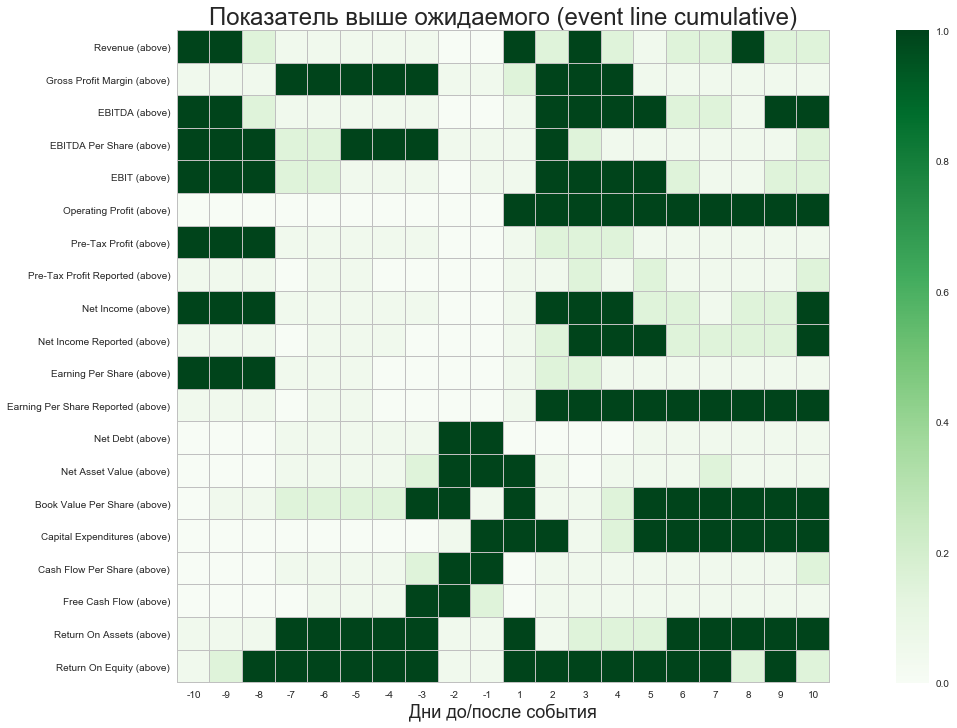

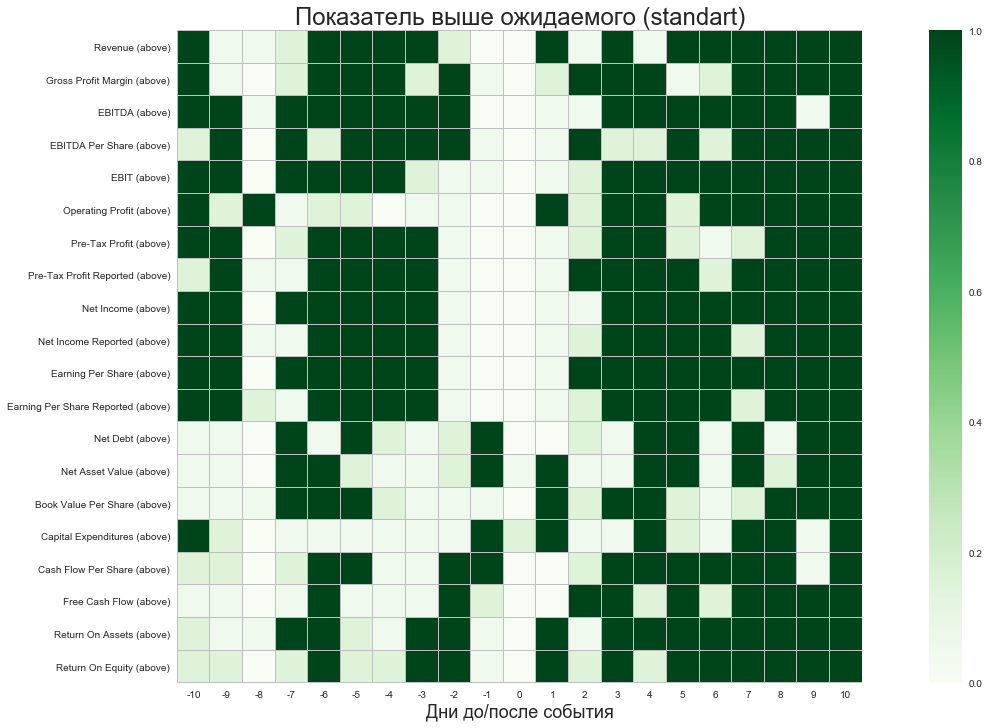

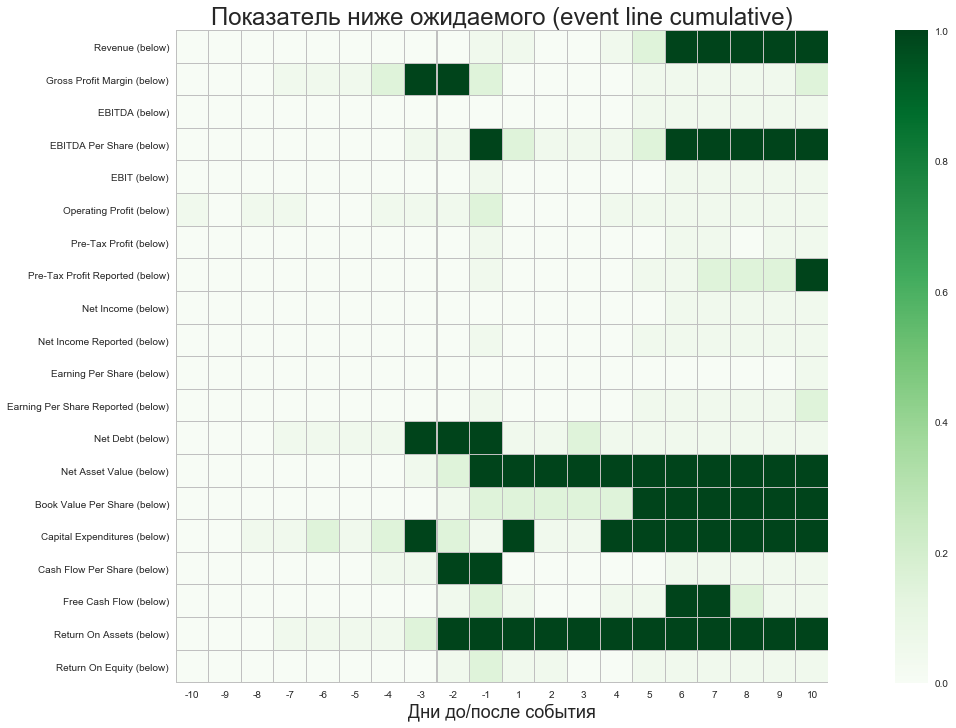

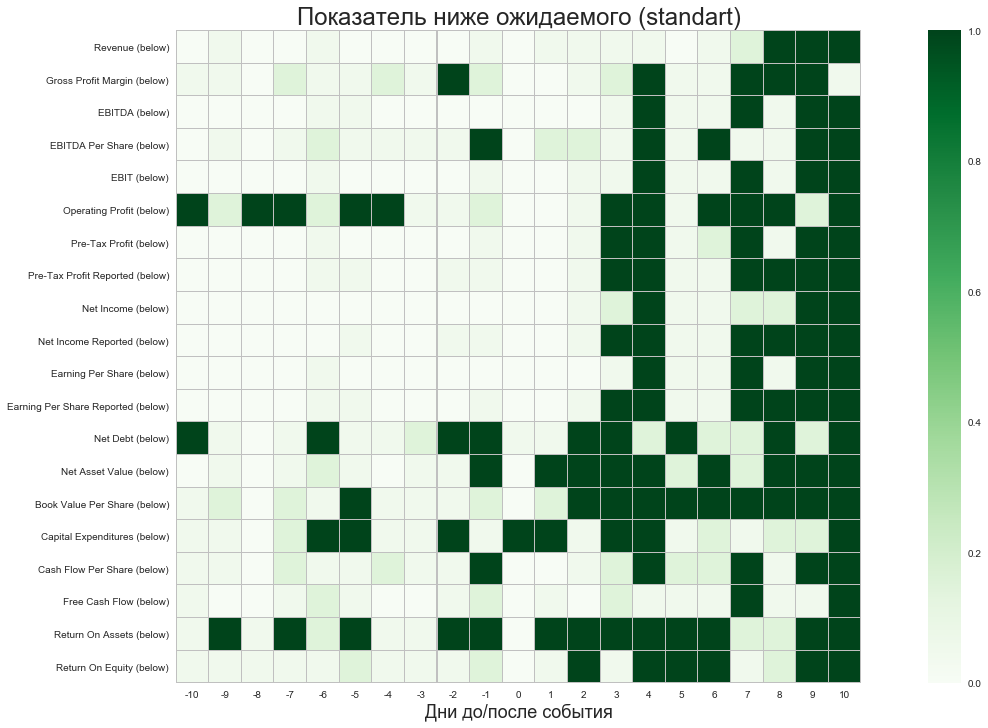

In [44]:
alpha  = [0., 0.05, 0.15]
#alpha = None
prename = './heatmaps/(Ab ret)'
savefig = False
cmap='Greens'

plot_heat(data = p_vals_event.iloc[::2,:].copy(), title = 'Показатель выше ожидаемого (event line cumulative)',
          alpha = alpha, savefig = savefig, prename =prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_standart.iloc[::2,:].copy(), title = 'Показатель выше ожидаемого (standart)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_event.iloc[1::2,:].copy(), title = 'Показатель ниже ожидаемого (event line cumulative)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);

plot_heat(data = p_vals_standart.iloc[1::2,:].copy(), title = 'Показатель ниже ожидаемого (standart)',
          alpha = alpha, savefig = savefig, prename=prename, cmap=cmap)
plt.gca().set_xlabel('Дни до/после события', fontsize=18);